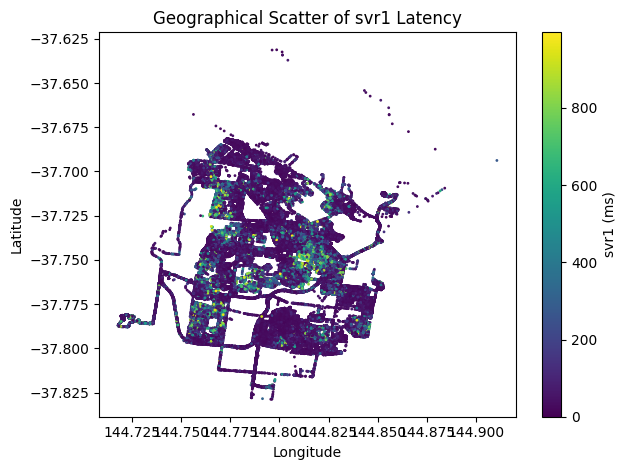

/tmp/ipykernel_240044/1718236809.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['svr1'].resample('H').mean()


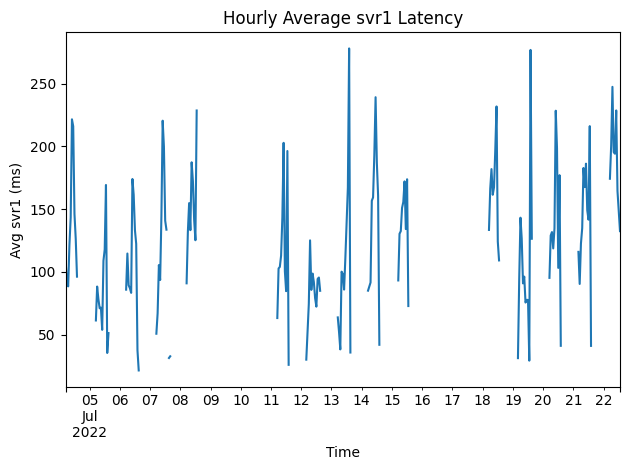

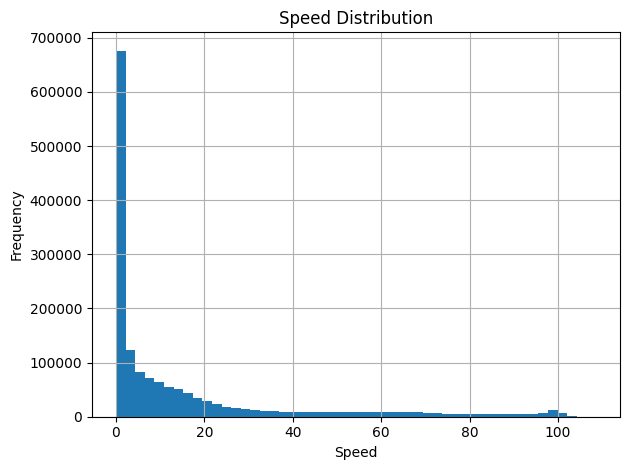

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the cleaned data (make sure Cleaned.csv is in your cwd)
df = pd.read_csv('Cleaned.csv', parse_dates=['datetime'], index_col='datetime')

# 2. Sample down for mapping clarity
df_sample = df.sample(n=100000, random_state=42)

# ────────────────────────────────────────────────────────────────────────────────
# A) Geographical scatter of svr1 (latency) over GPS coordinates
plt.figure()
plt.scatter(
    df_sample['longitude'],
    df_sample['latitude'],
    c=df_sample['svr1'],     # color-coded by svr1
    s=1                      # very small dots
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Scatter of svr1 Latency')
plt.colorbar(label='svr1 (ms)')
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# B) Time series: hourly average svr1 latency
df_hourly = df['svr1'].resample('H').mean()
plt.figure()
df_hourly.plot()
plt.xlabel('Time')
plt.ylabel('Avg svr1 (ms)')
plt.title('Hourly Average svr1 Latency')
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# C) Distribution of truck speeds
plt.figure()
df['speed'].hist(bins=50)
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Speed Distribution')
plt.tight_layout()
plt.show()


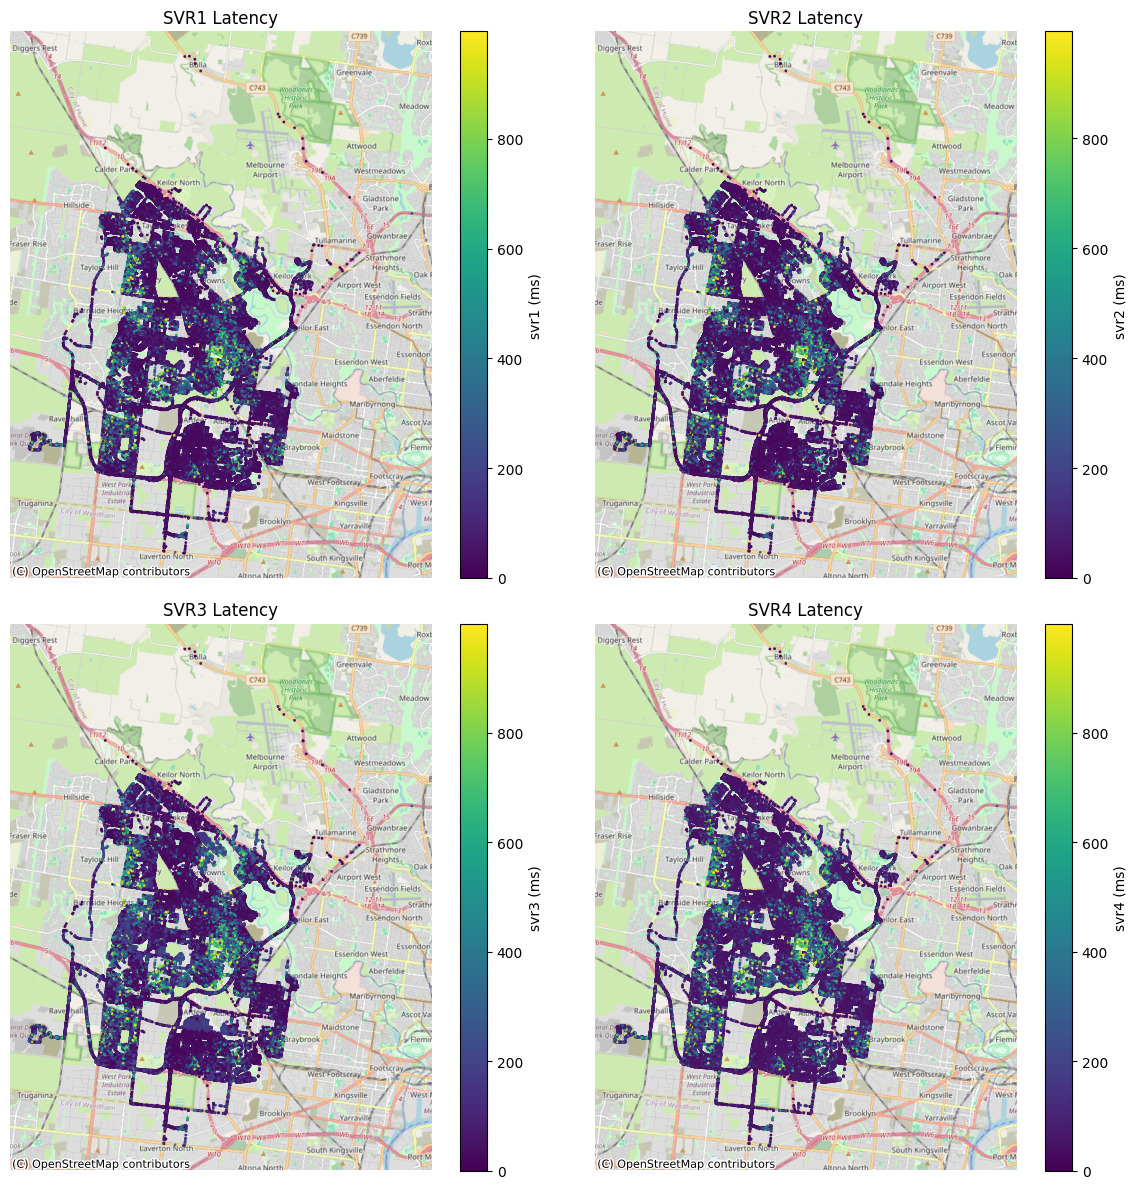

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Attempt to import contextily for map background
try:
    import contextily as ctx
    HAS_CTX = True
except ImportError:
    HAS_CTX = False

# 1. Load and sample your cleaned data
df = pd.read_csv('Cleaned.csv', parse_dates=['datetime']).set_index('datetime')
df_sample = df.sample(100_000, random_state=42)

# 2. Convert to GeoDataFrame (WGS84 -> Web Mercator for mapping)
gdf = gpd.GeoDataFrame(
    df_sample,
    geometry=gpd.points_from_xy(df_sample.longitude, df_sample.latitude),
    crs='EPSG:4326'
).to_crs(epsg=3857)

# 3. Plot each svr latency on a map
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
svr_cols = ['svr1', 'svr2', 'svr3', 'svr4']

for ax, svr in zip(axes.flat, svr_cols):
    # Plot geo-points colored by svr latency
    gdf.plot(ax=ax, column=svr, markersize=1, legend=False)
    
    # Add a basemap: default to OpenStreetMap if Stamen unavailable
    if HAS_CTX:
        provider = getattr(ctx.providers, 'OpenStreetMap', ctx.providers)[ 'Mapnik' ] \
            if hasattr(ctx.providers, 'OpenStreetMap') else list(ctx.providers.values())[0]
        ctx.add_basemap(ax, source=provider)
    
    ax.set_axis_off()
    title = f'{svr.upper()} Latency'
    if not HAS_CTX:
        title += '\n(install contextily for map background)'
    ax.set_title(title)
    
    # Create colorbar
    vmin, vmax = gdf[svr].min(), gdf[svr].max()
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, ax=ax, label=f'{svr} (ms)')

plt.tight_layout()
plt.show()
